In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="f32xFqYKZCtMrVK7IGmM")
project = rf.workspace("potatao-weeds").project("sesame-weed-detection")
version = project.version(2)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to sesame-weed-detection-2 in coco:: 100%|██████████| 1306/1306 [00:01<00:00, 1033.48it/s]


In [ ]:
!pip install -q coco-eval

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install datasets pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import shutil
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torchvision
from transformers import DetrImageProcessor, DetrForObjectDetection
from torchvision.transforms import Normalize, Resize, ToTensor, Compose, ToPILImage
from datasets import load_dataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pytorch_lightning as pl
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_dir, processor):
      annot_file_path = os.path.join(img_dir, '_annotations.coco.json')
      super().__init__(img_dir, annot_file_path)
      self.processor = processor

    def __getitem__(self, idx):
      img, target = super().__getitem__(idx)
      img_id = self.ids[idx]
      target = {'image_id': img_id, 'annotations': target}
      encoding = self.processor(images=img, annotations=target, return_tensors="pt")
      pixel_values = encoding["pixel_values"].squeeze()
      target = encoding["labels"][0]
      return pixel_values, target

In [ ]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_dir='/content/sesame-weed-detection-2/train', processor=processor)
val_dataset = CocoDetection(img_dir='/content/sesame-weed-detection-2/test', processor=processor)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 1210
Number of validation examples: 90


Image n°619


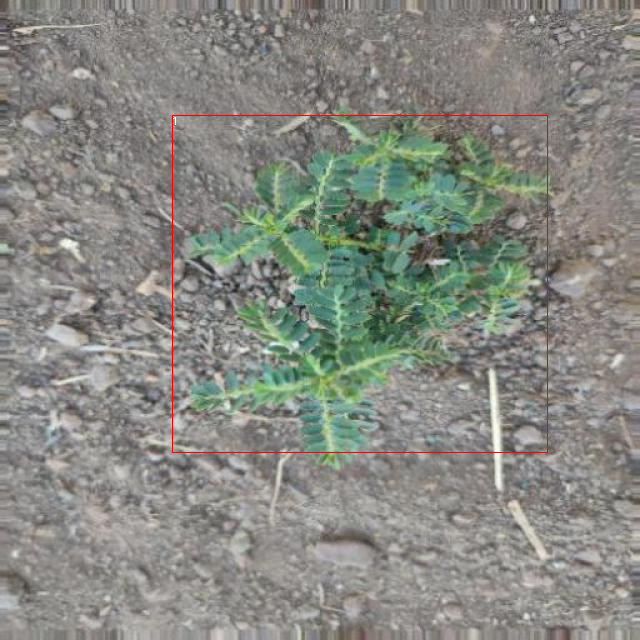

In [ ]:
image_ids = train_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/sesame-weed-detection-2/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [ ]:
def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [ ]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [ ]:
pixel_values, target = train_dataset[0]
print(pixel_values.shape)
print(target)

torch.Size([3, 800, 800])
[{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([2]), 'boxes': tensor([[0.5035, 0.6523, 0.7852, 0.6078]]), 'area': tensor([305425.7812]), 'iscrowd': tensor([0]), 'orig_size': tensor([640, 640])}]


In [ ]:
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
outputs.logits.shape

torch.Size([4, 100, 4])

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=300, gradient_clip_val=0.1)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
18.0 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.009   Total estimated model params size (MB)
0         Modules in train mode
467       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=300` reached.


In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0.3)
    print(results)


    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/45 [00:00<?, ?it/s]

[{'scores': tensor([0.5565], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'boxes': tensor([[177.3721, 221.9964, 502.0966, 459.8596]], device='cuda:0')}, {'scores': tensor([0.3946], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'boxes': tensor([[239.3786, 240.0027, 408.3151, 377.5062]], device='cuda:0')}]
[{'scores': tensor([0.3234, 0.3626, 0.5118], device='cuda:0'), 'labels': tensor([1, 2, 2], device='cuda:0'), 'boxes': tensor([[423.0068, 130.9778, 494.5108, 245.1168],
        [ 58.1038, 113.8503, 602.0001, 499.7962],
        [139.7321, 197.2890, 509.9278, 532.7531]], device='cuda:0')}, {'scores': tensor([0.4561, 0.5360], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'boxes': tensor([[ 35.6230,  72.6611, 636.5153, 541.3638],
        [ 50.1091,  74.1356, 636.4069, 500.8749]], device='cuda:0')}]
[{'scores': tensor([0.5515, 0.5365], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'boxes': tensor([[  4.5943,  79.4402, 641.2363, 574.4235]

Confidence scores are pretty low

In [ ]:
pixel_values, target = val_dataset[4]
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 800])


In [ ]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

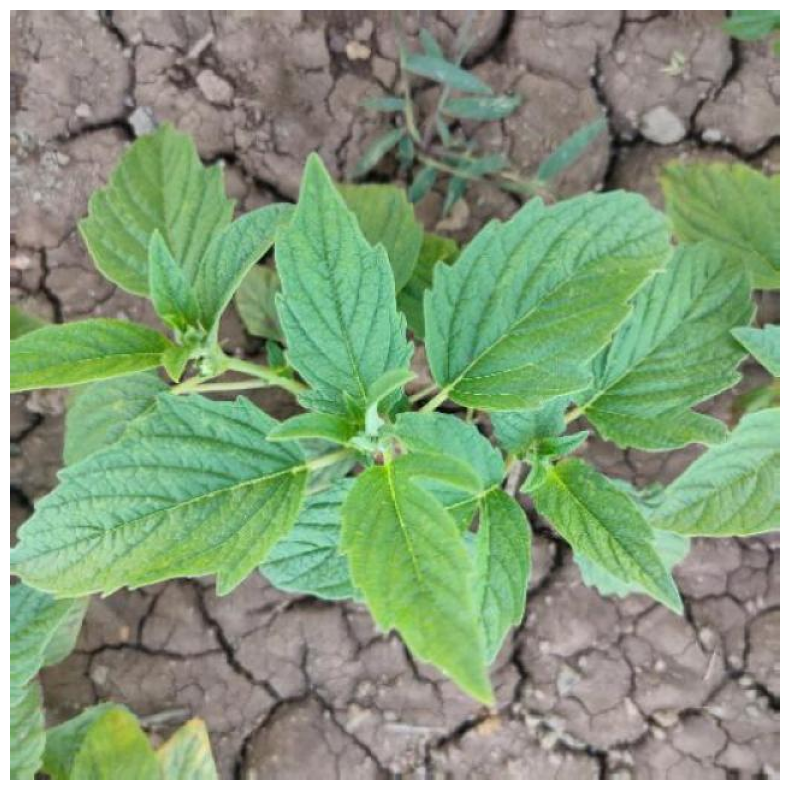

In [ ]:
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/sesame-weed-detection-2/test', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.6)  #no bounding boxes with more than 0.6 confidence score.
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])